# Mount drive, import libraries, Hyperparameters

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/AI'

Mounted at /content/drive
/content/drive/MyDrive/AI


In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.autograd as autograd
torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0'

In [4]:
!pip install pyvi
from pyvi import ViPosTagger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 2.0 MB/s 
     |████████████████████████████████| 965 kB 44.9 MB/s 


# Read Pretrained data

In [ ]:
pretrain_data_0 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 1, nrows = 100000)
pretrain_data_1 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 100001, nrows = 100000)
pretrain_data_2 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 200001, nrows = 100000)
pretrain_data_3 = pd.read_csv('pretrained100.txt', sep=" ",header = None, skiprows = 300001, nrows = 100000)
pretrain_data = pd.concat([pretrain_data_0, pretrain_data_1, pretrain_data_2, pretrain_data_3])

In [ ]:
print(pretrain_data.shape)
pretrain_data.head()

(400000, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,",",-0.013445,0.082912,0.095113,0.052493,0.069441,-0.010651,0.004321,-0.082824,0.051480,...,-0.099876,0.020649,-0.066902,0.077416,-0.147332,-0.021268,0.019100,-0.138095,0.077689,-0.210762
1,.,0.080173,0.048418,0.058027,0.055044,0.023451,-0.000025,0.000599,-0.071703,0.054242,...,-0.183366,0.039830,-0.010186,0.075011,-0.128598,-0.020384,0.029758,-0.172362,0.126670,-0.188354
2,và,0.013720,0.058717,0.110645,0.066075,0.046535,-0.004956,-0.003579,-0.033581,0.043340,...,-0.128276,-0.011903,-0.048510,0.085721,-0.133140,0.005551,0.043090,-0.154915,0.148186,-0.196749
3,của,0.026101,0.033375,0.166609,0.013060,0.017971,0.006579,0.067402,0.002216,0.116908,...,-0.137093,0.036225,-0.026152,0.148379,-0.151303,-0.039304,0.016051,-0.123603,0.107642,-0.222042
4,là,0.031769,0.048661,0.138932,-0.068711,0.049129,-0.014016,0.066129,0.013496,0.028830,...,-0.124612,0.031029,-0.069093,0.085157,-0.106477,-0.006654,-0.006391,-0.161527,0.107603,-0.208509


In [ ]:
word_embedding_dict = {}
border = np.sqrt(3/100)
count = 0
for word in list_of_words:
  if pretrain_data.loc[pretrain_data[0] == word].shape[0] == 0:
    word_embedding_dict[word] = np.random.uniform(-border,border, 100).tolist()
  else:
    temp = []
    for x in range(1, 101):
      _ = pretrain_data.loc[pretrain_data[0] == word, x].values[0]
      temp.append(_)
    word_embedding_dict[word] = temp

In [ ]:
len(word_embedding_dict)

7886

In [ ]:
import pickle

In [ ]:
import pickle
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(word_embedding_dict, f)

"with open('saved_dictionary.pkl', 'rb') as f:\n    loaded_dict = pickle.load(f)"

# Data Preprocessing

In [47]:
with open('saved_dictionary.pkl', 'rb') as f: #read from a pretrained word-embedding file
    loaded_dict = pickle.load(f)

border = np.sqrt(3/100)
loaded_dict['<UNK>'] = np.random.uniform(-border,border, 100).tolist()

In [48]:
trainset = pd.read_csv('train_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {trainset.shape}")
trainset.head(3)

Dataset's shape: (5027, 2)


,sent,anno
0,"Đồng_thời , bệnh_viện tiếp_tục thực_hiện các b...",O O O O O O O O O O O O O O O B-ORGANIZATION I...
1,""" Số bệnh_viện có_thể tiếp_nhận bệnh_nhân bị s...",O O O O O O O B-SYMPTOM_AND_DISEASE I-SYMPTOM_...
2,"Ngoài_ra , những người tiếp_xúc gián_tiếp ( đã...",O O O O O O O O O O O O O O O O O O O O O O O ...


In [49]:
testset = pd.read_csv('test_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {testset.shape}")
testset.head(3)

Dataset's shape: (4000, 2)


,sent,anno
0,"Từ 24 - 7 đến 31 - 7 , bệnh_nhân được mẹ là bà...",O B-DATE I-DATE I-DATE O B-DATE I-DATE I-DATE ...
1,"Bác_sĩ Trần_Thanh_Linh , từ Bệnh_viện Chợ_Rẫy ...",O O O O B-ORGANIZATION I-ORGANIZATION O O O O ...
2,"Theo đó , Sở Y_tế Bình_Thuận cho biết sau khi ...",O O O B-ORGANIZATION I-ORGANIZATION I-ORGANIZA...


In [50]:
validset = pd.read_csv('val_word.csv')[['sent', 'anno']]
print(f"Dataset's shape: {validset.shape}")
validset.head(3)

Dataset's shape: (1000, 2)


,sent,anno
0,"Bác_sĩ Nguyễn_Trung_Nguyên , Giám_đốc Trung_tâ...",O O O O B-ORGANIZATION I-ORGANIZATION I-ORGANI...
1,""" Bệnh_nhân 812 "" , nam , 62 tuổi , là nhân_vi...",O O B-PATIENT_ID O O B-GENDER O B-AGE O O O B-...
2,Trong số những người mà cô ấy đã tiếp_xúc với ...,O O O O O O O O O O O O B-ORGANIZATION O


In [51]:
word_to_ix = {}
tag_to_ix = {}
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix[START_TAG] = 0
tag_to_ix[STOP_TAG] = 1
word_to_ix['UNK'] = 0

for sentences, tags in zip(trainset['sent'].tolist(),trainset['anno'].tolist()):
  for word in sentences.split():
    if word not in word_to_ix.keys():
      word_to_ix[word] = len(word_to_ix)
  for tag in tags.split():
    if tag not in tag_to_ix.keys():
      tag_to_ix[tag] = len(tag_to_ix)

In [52]:
print(tag_to_ix)

{'<START>': 0, '<STOP>': 1, 'O': 2, 'B-ORGANIZATION': 3, 'I-ORGANIZATION': 4, 'B-SYMPTOM_AND_DISEASE': 5, 'I-SYMPTOM_AND_DISEASE': 6, 'B-LOCATION': 7, 'B-DATE': 8, 'B-PATIENT_ID': 9, 'B-AGE': 10, 'B-NAME': 11, 'I-DATE': 12, 'B-JOB': 13, 'I-LOCATION': 14, 'B-TRANSPORTATION': 15, 'B-GENDER': 16, 'I-TRANSPORTATION': 17, 'I-JOB': 18, 'I-NAME': 19, 'I-AGE': 20, 'I-PATIENT_ID': 21}


In [53]:
print(f"Number of distinct words: {len(word_to_ix)-1}")

Number of distinct words: 5167


In [54]:
word2tag = dict()
word2tag['word'] = list()
word2tag['tag'] = list()

for sentences, tags in zip(trainset['sent'].tolist(), trainset['anno'].tolist()):
  for word, tag in zip (sentences.split(), tags.split()):
    word2tag['word'].append(word)
    word2tag['tag'].append(tag)
dataset_df = pd.DataFrame(word2tag)

In [55]:
dataset_df.head()

,word,tag
0,Đồng_thời,O
1,",",O
2,bệnh_viện,O
3,tiếp_tục,O
4,thực_hiện,O


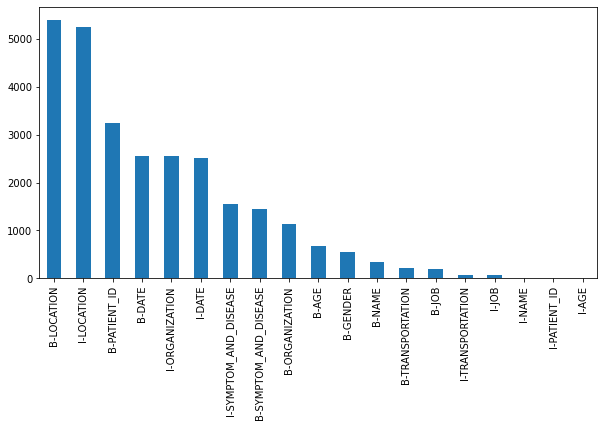

In [56]:
dataset_df[dataset_df["tag"]!="O"]["tag"].value_counts().plot(kind="bar", figsize=(10,5))

In [57]:
'''#word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts_list = [len(sent[0]) for sent in data]
word_counts = pd.DataFrame(word_counts_list)
print(f"Longest sentence in the corpus contains {max(word_counts_list)} words.")
print(f"Longest sentence: {' '.join(data[np.argmax(np.array(word_counts_list))][0])}.")
print(f"We can see the average length of sentence in the corpus is about 20 words\n")
word_counts.hist(bins=50, figsize=(8,6));'''

'#word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])\nword_counts_list = [len(sent[0]) for sent in data]\nword_counts = pd.DataFrame(word_counts_list)\nprint(f"Longest sentence in the corpus contains {max(word_counts_list)} words.")\nprint(f"Longest sentence: {\' \'.join(data[np.argmax(np.array(word_counts_list))][0])}.")\nprint(f"We can see the average length of sentence in the corpus is about 20 words\n")\nword_counts.hist(bins=50, figsize=(8,6));'

In [58]:
print(f"Number of unique tag is {len(tag_to_ix)-2}")
print(f"Number of unique word is {len(word_to_ix)}")

Number of unique tag is 20
Number of unique word is 5168


In [59]:
full_text = ""

for word in word_to_ix.keys():
  full_text += word
  full_text += " "

int2char = dict(enumerate(set(full_text)))
char2int = {ch: ii for ii, ch in int2char.items()}
int2char[len(char2int)] = 'UNK'
char2int['UNK'] = len(char2int)

list_of_pos = {
    'X': 0,  #<Unk>
    'A': 1,
    'C': 2,
    'E': 3,
    'I': 4,
    'L': 5,
    'M': 6,
    'N': 7,
    'Nc': 8,
    'Ny': 9,
    'Np': 10,
    'Nu': 11,
    'P': 12,
    'R': 13,
    'S': 14,
    'T': 15,
    'V': 16,
    'F': 17
}

def one_hot_encode(index, n_labels):
    one_hot = [0] * n_labels
    one_hot[index] = 1
    return one_hot

In [60]:
print(char2int)

{'Ư': 0, 'ẵ': 1, 'ố': 2, ':': 3, 't': 4, 'a': 5, 'H': 6, 'ạ': 7, 'O': 8, 'ề': 9, '?': 10, 'ỏ': 11, 'ằ': 12, 'ẽ': 13, 'ễ': 14, 'E': 15, 'e': 16, 'X': 17, 'h': 18, 'x': 19, 'M': 20, 'u': 21, '4': 22, 'J': 23, 'ủ': 24, 'z': 25, 'Ý': 26, 'ử': 27, 'ĩ': 28, 'F': 29, 'í': 30, 'Í': 31, 'ậ': 32, 'đ': 33, 'N': 34, 'ặ': 35, 'ẻ': 36, 'ứ': 37, '-': 38, 'Ĩ': 39, ')': 40, 'ấ': 41, 'b': 42, 'Ễ': 43, 'ỗ': 44, 'i': 45, 'ệ': 46, '8': 47, 'k': 48, 'ắ': 49, 'ô': 50, 'ũ': 51, 'U': 52, ' ': 53, 'Y': 54, 's': 55, 'ự': 56, 'ả': 57, 'A': 58, 'ợ': 59, 'ổ': 60, 'P': 61, 'ị': 62, '1': 63, 'ú': 64, '…': 65, 'B': 66, '&': 67, 'ỡ': 68, 'L': 69, 'ụ': 70, 'Ú': 71, 'Đ': 72, 'R': 73, '*': 74, '“': 75, 'Á': 76, ';': 77, '_': 78, 'd': 79, 'v': 80, 'ẳ': 81, '.': 82, 'ỹ': 83, '7': 84, 'm': 85, 'q': 86, 'I': 87, 'Ổ': 88, 'ẫ': 89, 'ư': 90, 'ể': 91, 'Â': 92, 'ì': 93, 'ầ': 94, 'ý': 95, 'f': 96, 'K': 97, 'ờ': 98, 'ó': 99, '\u200b': 100, 'y': 101, 'c': 102, '5': 103, 'p': 104, 'ọ': 105, 'D': 106, 'T': 107, 'ẩ': 108, 'ỵ': 109, 'ộ':

In [61]:
training_data = []
for sent, tag in zip(trainset['sent'].tolist(), trainset['anno'].tolist()):
  list_word = sent.split()
  embed = []
  sequence_pos = []
  list_tag = [tag_to_ix[t] for t in tag.split()]
  sequence_char = []
  for word in list_word:
    embed.append(loaded_dict[word])
    temp = []
    for ch in list(word):
      temp.append(char2int[ch])
    sequence_char.append(temp)
  for pos in ViPosTagger.postagging(sent)[1]:
    sequence_pos.append(one_hot_encode(list_of_pos[pos], len(list_of_pos)))

  training_data.append((list_word, embed, list_tag, sequence_pos, sequence_char))

In [62]:
validating_data = []
for sent, tag in zip(validset['sent'].tolist(), validset['anno'].tolist()):
  list_word = sent.split()
  embed = []
  sequence_pos = []
  list_tag = [tag_to_ix[t] for t in tag.split()]
  sequence_char = []
  for word in list_word:
    if word not in loaded_dict:
      embed.append(loaded_dict['UNK'])
    else:
      embed.append(loaded_dict[word])
    temp = []
    for ch in list(word):
      if ch not in char2int:
        temp.append(char2int['UNK'])
      else:
        temp.append(char2int[ch])
    sequence_char.append(temp)
  for pos in ViPosTagger.postagging(sent)[1]:
    sequence_pos.append(one_hot_encode(list_of_pos[pos], len(list_of_pos)))

  validating_data.append((list_word, embed, list_tag, sequence_pos, sequence_char))

In [63]:
print(training_data[10][0])
print(training_data[10][2])
print(training_data[10][3])
print(training_data[10][4])

['Hôm_qua', ',', 'hai', 'bệnh_nhân', 'Covid', '-', '19', 'cũng', 'tử_vong', ',', 'có', 'bệnh', 'nền', 'suy', 'thận', 'mạn', '.']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 2]
[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [65]:
print(len(training_data))
print(len(validating_data))

5027
1000


# Model

In [44]:
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

def generate_batch(df, size):
    sent_list = []
    embeds_list = []
    tags_list = []
    pos_list = []
    char_list = []
    for item in df:
        sent_list.append(item[0])
        embeds_list += item[1]
        tags_list += item[2]
        pos_list += item[3]
        char_list += item[4]
        if len(sent_list) == size:
            yield sent_list, embeds_list, tags_list, pos_list, char_list
            sent_list = []
            embeds_list = []
            tags_list = []
            pos_list = []
            char_list = []
            
class CharEmbedding(nn.Module):
  def __init__(self, embeddingSize ,hiddenSize, charSize):
    super(CharEmbedding, self).__init__()
    self.embeddingSize = embeddingSize
    self.hiddenSize = hiddenSize
    self.embed = nn.Embedding(charSize, embeddingSize)
    self.BiLSTM = nn.LSTM(embeddingSize, hiddenSize, batch_first = True, bidirectional=True)

  def forward(self, sentence):
    embeddingMatrix = torch.empty(size = (len(sentence), self.hiddenSize*2))
    hidden, cell = (torch.randn(2, 1, self.hiddenSize),
                    torch.randn(2, 1, self.hiddenSize))
    for i, word in enumerate(sentence):
      for char in word:
        embeds = self.embed(torch.tensor(char))
        out, (hidden, cell) = self.BiLSTM(embeds.view(1, 1, -1), (hidden, cell))
      embeddingMatrix[i] = out
    return embeddingMatrix

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = (torch.randn(2, 1, self.hidden_dim // 2),torch.randn(2, 1, self.hidden_dim // 2))
        return hidden

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas
        forward_var = forward_var
        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = sentence.view(len(sentence), 1, -1)     #self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        forward_var = forward_var
        
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

# WordEmbedding

In [89]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [92]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
import time

patience = 3
trigger = 0

list_word = []
list_tag = []

for i in range(len(validating_data)):
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])

with torch.no_grad():
  test = torch.tensor(list_word, dtype = torch.float32)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        

        inputs = torch.tensor(embeds, dtype = torch.float32)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")
        if index == 5:
          break      
    with torch.no_grad():
      test = torch.tensor(list_word, dtype = torch.float32)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
    if trigger == patience:
      break
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbed.pt')

# WordEmbedding + Char

In [70]:
EMBEDDING_DIM = 150
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [71]:
charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

In [ ]:
import time

patience = 3
trigger = 0

list_word = []
list_tag = []
list_char = []
for i in range(len(validating_data)):
    list_char.extend(validating_data[i][-1])
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])

with torch.no_grad():
  out = charModel(list_char)
  test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out), dim = 1)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        charModel.zero_grad()

        embeds = torch.tensor(embeds, dtype = torch.float32)
        char = charModel(char)
        inputs = torch.cat((embeds, char), dim=1)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ")      
    with torch.no_grad():
      out = charModel(list_char)
      test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out), dim = 1)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
    if trigger == patience:
      break
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedChar.pt')

# WordEmbedding + Char + POS

In [80]:
EMBEDDING_DIM = 168
HIDDEN_DIM = 200

#char
embeddingSize = 10
hiddenSize = 25
charSize = len(char2int)

EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [84]:
charModel = CharEmbedding(embeddingSize, hiddenSize, charSize)
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)

optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': charModel.parameters(), 'lr': 1e-3}
            ], lr=1e-3)

In [ ]:
import time

patience = 3
trigger = 0

list_word = []
list_tag = []
list_char = []
list_pos = []
for i in range(len(validating_data)):
    list_char.extend(validating_data[i][-1])
    list_word.extend(validating_data[i][1])
    list_tag.extend(validating_data[i][2])
    list_pos.extend(validating_data[i][3])

with torch.no_grad():
  out = charModel(list_char)
  test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
  last_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
  print(f"Validation Loss before training: {last_loss}")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    start_time = time.time()

    for index, (sent, embeds, tags, pos, char) in enumerate(generate_batch(training_data, BATCH_SIZE)):
        model.zero_grad()
        charModel.zero_grad()

        embeds = torch.tensor(embeds, dtype = torch.float32)
        pos = torch.tensor(pos, dtype = torch.float32)
        char = charModel(char)
        inputs = torch.cat((embeds, char, pos), dim=1)

        targets = torch.tensor(tags)

        train_loss = model.neg_log_likelihood(inputs, targets)
        train_loss.backward()
        optimizer.step()
      
        print(index, end = " ") 
        if index == 10:
          break     
    with torch.no_grad():
      out = charModel(list_char)
      test = torch.cat((torch.tensor(list_word, dtype = torch.float32), out, torch.tensor(list_pos, dtype = torch.float32)), dim = 1)
      current_loss = model.neg_log_likelihood(test, torch.tensor(list_tag)).item()
    if current_loss > last_loss:
      trigger += 1
    else:
      last_loss = current_loss
    if trigger == patience:
      break
    print(f"epoch {epoch+1}/{EPOCHS} with time: {time.time() - start_time} - validloss: {current_loss}") 
    start_time = time.time()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/WordEmbedCharPOS.pt')